In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing, model_selection
import lightgbm as lgb
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_columns = 100

In [2]:
!ls ../input/

Data Dictionary.xlsx  test_bqCt9Pv.csv	train_aox2Jxw.zip
__MACOSX	      test_bqCt9Pv.zip	train.csv


In [3]:

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test_bqCt9Pv.csv")
print(train_df.shape, test_df.shape)

(233154, 41) (112392, 40)


In [4]:
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [5]:
train_df["loan_default"].value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

In [6]:
import datetime as dt
date_cols = ["Date.of.Birth"]
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], format="%d-%m-%y")
    test_df[col] = pd.to_datetime(test_df[col], format="%d-%m-%y")
    
    train_df[col + "_in_seconds"] = (train_df[col] - dt.datetime(1970,1,1)).dt.total_seconds()
    test_df[col + "_in_seconds"] = (test_df[col] - dt.datetime(1970,1,1)).dt.total_seconds()
    
    train_df[col + "_year"] = train_df[col].dt.year
    test_df[col + "_year"] = test_df[col].dt.year
    
    train_df[col + "_month"] = train_df[col].dt.month
    test_df[col + "_month"] = test_df[col].dt.month
    

In [7]:
train_df["DisbursalDate"] = pd.to_datetime(train_df["DisbursalDate"], format="%d-%m-%y")
test_df["DisbursalDate"] = pd.to_datetime(test_df["DisbursalDate"], format="%d-%m-%y")

train_df["DisbursalMonth"] = train_df["DisbursalDate"].dt.month
test_df["DisbursalMonth"] = test_df["DisbursalDate"].dt.month

train_df["DisbursalDay"] = train_df["DisbursalDate"].dt.day
test_df["DisbursalDay"] = test_df["DisbursalDate"].dt.day

train_df["DisbursalWeekDay"] = train_df["DisbursalDate"].dt.weekday
test_df["DisbursalWeekDay"] = test_df["DisbursalDate"].dt.weekday

In [8]:
def get_num_months(x):
    x = str(x).split()
    yr = int(x[0].replace("yrs",""))
    mnth = int(x[1].replace("mon",""))
    return ((yr*12) + mnth)

for col in ["AVERAGE.ACCT.AGE", "CREDIT.HISTORY.LENGTH"]:
    train_df[col] = train_df[col].apply(lambda x: get_num_months(x))
    test_df[col] = test_df[col].apply(lambda x: get_num_months(x))

In [9]:
train_df.head(20)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Date.of.Birth_in_seconds,Date.of.Birth_year,Date.of.Birth_month,DisbursalMonth,DisbursalDay,DisbursalWeekDay
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-08-03,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.417632e+08,1984,1,8,3,4
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1,4.916160e+08,1985,7,9,26,2
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,2018-08-01,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.936896e+08,1985,8,8,1,2
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,8,15,1,1,7.572096e+08,1993,12,10,26,4
4,539055,52378,60300,88.39,67,22807,45,1495,1977-12-09,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2.504736e+08,1977,12,9,26,2
5,518279,54513,61900,89.66,67,22807,45,1501,1990-09-08,Self employed,2018-09-19,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,21,24,0,0,6.527520e+08,1990,9,9,19,2
6,529269,46349,61500,76.42,67,22807,45,1502,1988-06-01,Salaried,2018-09-23,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.811264e+08,1988,6,9,23,6
7,510278,43894,61900,71.89,67,22807,45,1501,1989-10-04,Salaried,2018-09-16,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,2,2,0,0,6.234624e+08,1989,10,9,16,6
8,490213,53713,61973,89.56,67,22807,45,1497,1991-11-15,Self employed,2018-09-05,6,1998,1,1,0,0,0,0,718,D-Very Low Risk,1,1,0,-41,365384,365384,0,0,0,0,0,0,0,0,0,0,56,56,1,0,6.901632e+08,1991,11,9,5,2
9,510980,52603,61300,86.95,67,22807,45,1492,2068-06-01,Salaried,2018-09-16,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,19,19,0,0,3.105734e+09,2068,6,9,16,6


In [10]:
train_df["employee_supplier"] = train_df["Employee_code_ID"].astype(str) + "_" + train_df["supplier_id"].astype('str')
test_df["employee_supplier"] = test_df["Employee_code_ID"].astype(str) + "_" + test_df["supplier_id"].astype('str')

In [11]:
for col in train_df.columns:
    if train_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

Employment.Type
PERFORM_CNS.SCORE.DESCRIPTION
employee_supplier


In [12]:

for col1, col2 in [
                   ["asset_cost", "disbursed_amount"],
                   ["PRI.DISBURSED.AMOUNT", "PRI.CURRENT.BALANCE"],
                  ]:
    train_df[col1 + "_diff_" + col2] = train_df[col1] - train_df[col2]
    test_df[col1 + "_diff_" + col2] = test_df[col1] - test_df[col2]

for col1, col2 in [["PRI.CURRENT.BALANCE", "PRI.DISBURSED.AMOUNT"],
                   ["PRI.DISBURSED.AMOUNT", "PRI.SANCTIONED.AMOUNT"],
                   ["AVERAGE.ACCT.AGE", "CREDIT.HISTORY.LENGTH"],
                   ["PRI.ACTIVE.ACCTS", "PRI.NO.OF.ACCTS"],
                   ["PRI.OVERDUE.ACCTS", "PRI.ACTIVE.ACCTS"],
                   ["PRI.OVERDUE.ACCTS", "PRI.NO.OF.ACCTS"],
                  ]:
    train_df[col1+"_ratio_"+col2] = train_df[col1] / train_df[col2]
    test_df[col1+"_ratio_"+col2] = test_df[col1] / test_df[col2]
    
    
### Count features
for col in ["Current_pincode_ID", "Employee_code_ID", "supplier_id", "branch_id", "ltv", 
            ["supplier_id", "branch_id"], ["supplier_id", "Employee_code_ID"],
            ["manufacturer_id", "branch_id"], ["manufacturer_id", "Employee_code_ID"],
            ["Employment.Type", "Employee_code_ID"], ["Employment.Type", "branch_id"],
            ["PERFORM_CNS.SCORE.DESCRIPTION", "Employee_code_ID"],
            ["Current_pincode_ID", "Employee_code_ID"],

           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["UniqueID"]+ col], test_df[["UniqueID"]+ col]])
    gdf = all_df.groupby(col)["UniqueID"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    
    
for col in ["Current_pincode_ID", "Employee_code_ID", "supplier_id",
           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["ltv"]+ col], test_df[["ltv"]+ col]])
    gdf = all_df.groupby(col)["ltv"].agg(["mean", "std", "max"]).reset_index()
    gdf.columns = col + [col_name+"_ltv_mean", col_name+"_ltv_std", col_name+"_ltv_max"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    

for col in ["Current_pincode_ID", "Employee_code_ID"
           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["PERFORM_CNS.SCORE"]+ col], test_df[["PERFORM_CNS.SCORE"]+ col]])
    gdf = all_df.groupby(col)["PERFORM_CNS.SCORE"].agg(["mean", "std"]).reset_index()
    gdf.columns = col + [col_name+"_performance_mean", col_name+"_performance_std"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    
    all_df = pd.concat([train_df[["Date.of.Birth_in_seconds"]+ col], test_df[["Date.of.Birth_in_seconds"]+ col]])
    gdf = all_df.groupby(col)["Date.of.Birth_in_seconds"].agg(["mean", "std"]).reset_index()
    gdf.columns = col + [col_name+"_dob_mean", col_name+"_dob_std"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    
    all_df = pd.concat([train_df[["disbursed_amount"]+ col], test_df[["disbursed_amount"]+ col]])
    gdf = all_df.groupby(col)["disbursed_amount"].agg(["mean", "std"]).reset_index()
    gdf.columns = col + [col_name+"_disamount_mean", col_name+"_disamount_std"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    
    all_df = pd.concat([train_df[["DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS"]+ col], test_df[["DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS"]+ col]])
    gdf = all_df.groupby(col)["DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS"].mean().reset_index()
    gdf.columns = col + [col_name+"_delinq_mean"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    
    all_df = pd.concat([train_df[["PRI.OVERDUE.ACCTS"]+ col], test_df[["PRI.OVERDUE.ACCTS"]+ col]])
    gdf = all_df.groupby(col)["PRI.OVERDUE.ACCTS"].mean().reset_index()
    gdf.columns = col + [col_name+"_overdue_mean"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    


In [14]:
cols_to_exclude = ["UniqueID", "loan_default", "DisbursalDate", "DisbursalMonth"]+date_cols
cols_to_use = [col for col in train_df.columns if col not in cols_to_exclude]
train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df["loan_default"].values
print(train_X.shape, test_X.shape)

(233154, 89) (112392, 89)


In [15]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=200):
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = dep
    params["num_leaves"] = 30
    params["min_data_in_leaf"] = data_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.35
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
    params["lambda_l2"] = 5
    params["lambda_l1"] = 5
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    #imps = model.feature_importance()
    #names = model.feature_name()
    #for fi, fn in enumerate(names):
    #    print(fn, imps[fi])

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [16]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 3
#kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
gkf = model_selection.GroupKFold(n_splits=n_splits)
model_name = "lgb"
for dev_index, val_index in gkf.split(train_X, train_df["loan_default"].values, train_df["DisbursalMonth"].values):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=8, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=7, data_leaf=100, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=9, data_leaf=150, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.65867
[1000]	valid_0's auc: 0.664105
[1500]	valid_0's auc: 0.665765
[2000]	valid_0's auc: 0.666527
[2500]	valid_0's auc: 0.666706
Early stopping, best iteration is:
[2550]	valid_0's auc: 0.666719
0.6667266369308217
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.657935
[1000]	valid_0's auc: 0.663383
[1500]	valid_0's auc: 0.665473
[2000]	valid_0's auc: 0.666131
[2500]	valid_0's auc: 0.666458
Early stopping, best iteration is:
[2630]	valid_0's auc: 0.666527
0.6665385912655211
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.658886
[1000]	valid_0's auc: 0.664268
[1500]	valid_0's auc: 0.665849
[2000]	valid_0's auc: 0.666386
Early stopping, best iteration is:
[2199]	valid_0's auc: 0.666573
0.6665804103504315
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.671226
[1000]	valid_0's

In [18]:
sub_df = pd.DataFrame(test_df[["UniqueID"]])
sub_df["loan_default"] = pred_test_full
sub_df.to_csv("sub6.csv", index=False)

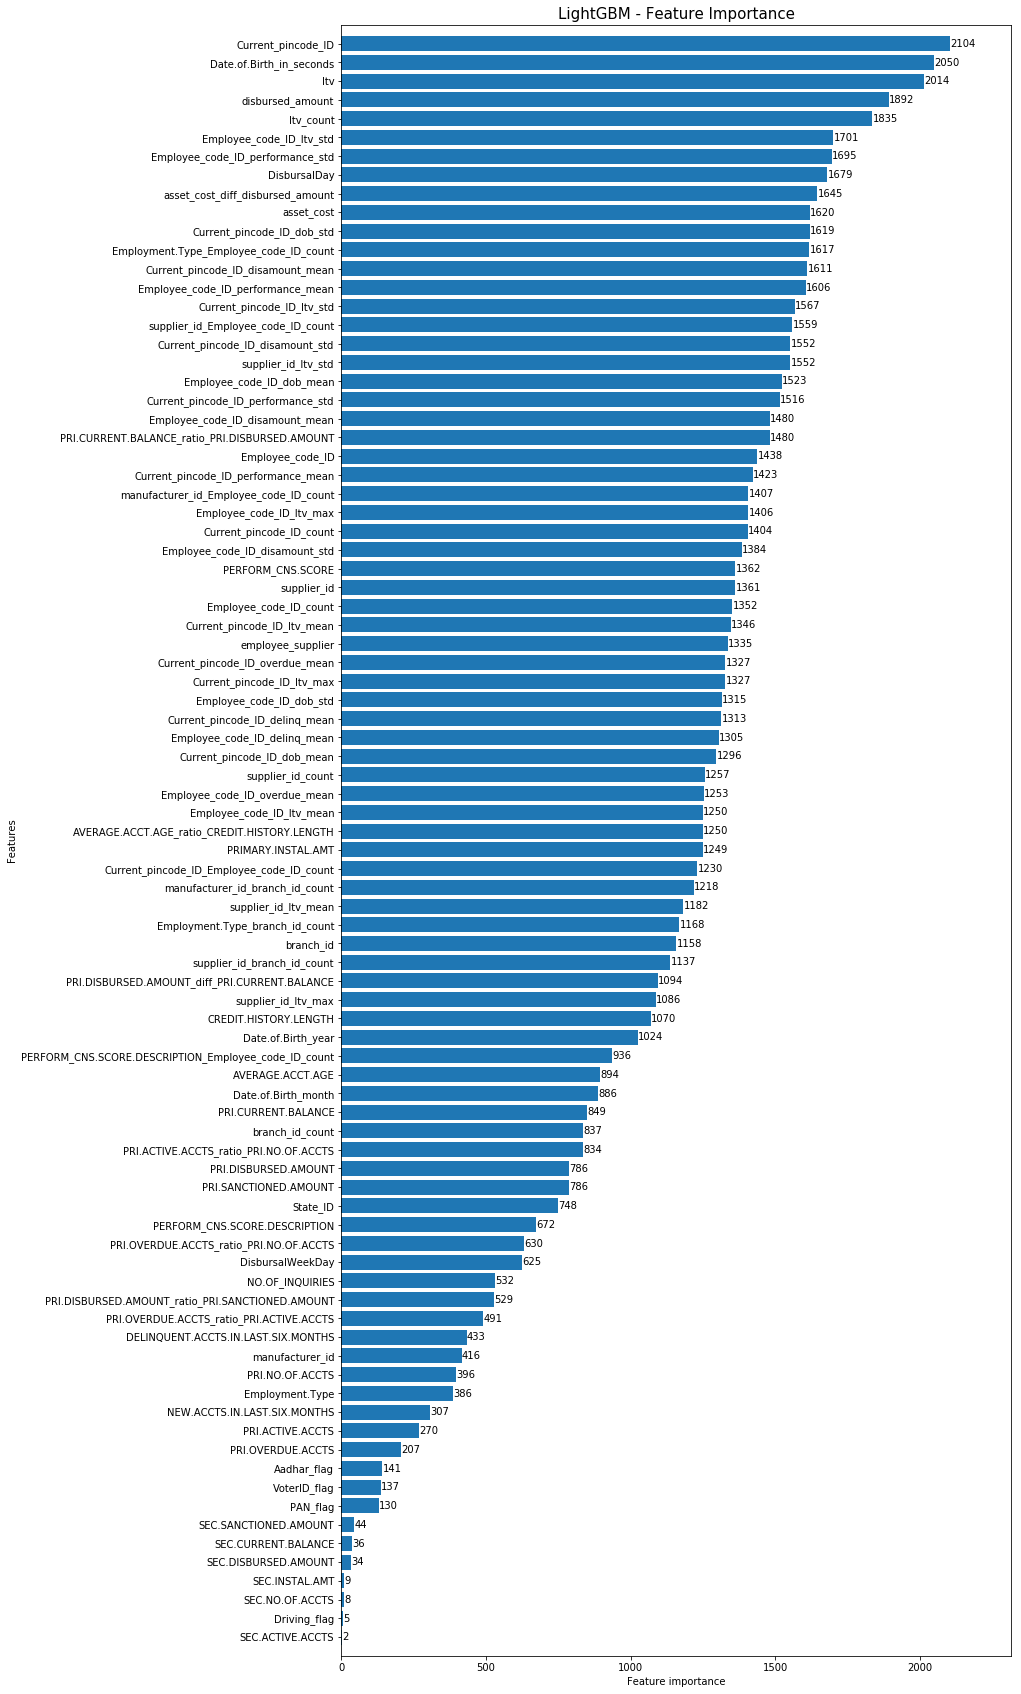

In [19]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()